In [1]:
import pandas as pd
import numpy as np

import pickle

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import RFE

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, BaggingRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.neural_network import MLPRegressor


import warnings

import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')

In this notebook, we will take our cleaned difference data and predict the goal difference using the supp data.

In [2]:
X = pd.read_csv('goal_diff_prediction/GD_training_data.csv')
y = pd.read_csv('Data/Y_train_supp.csv', index_col = "ID")
y.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12303 entries, 0 to 12302
Data columns (total 1 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   GOAL_DIFF_HOME_AWAY  12303 non-null  float64
dtypes: float64(1)
memory usage: 192.2 KB


Our approach to predicting the GD will be as follows:

 1. Using a linear model and forwards stepwise selection, we will limit the number of features in order to limit potential overfitting problems.
 2. Use various regression models to fit our data set. We will try fitting with the correct data proportions and on a data set where we have upsampled so that the number of each data points with each GD are the same.  
 3. Hyper-param tuning.
 4. Make GD predictions for our training data set.
 5. Save predictions and models.

Before we begin, we'll split our data

In [3]:
X_train, X_test, y_train, y_test   = train_test_split(X,y, random_state = 48,test_size=0.2)
X_train, X_valid, y_train, y_valid = train_test_split(X,y, random_state = 48,test_size=0.2)

Before we try and fit the different models, we will have a quick look at the data:

min:-13, max: 9


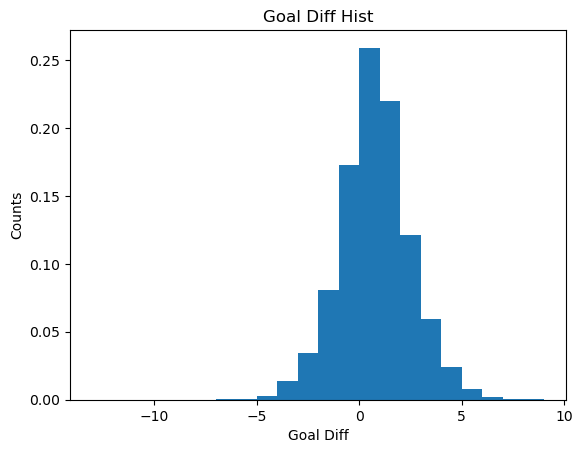

In [4]:
bins = range(int(y['GOAL_DIFF_HOME_AWAY'].min()), int(y['GOAL_DIFF_HOME_AWAY'].max()))
print(f"min:{bins[0]}, max: {bins[-1]}")
plt.hist(y, bins = bins, density=True)
plt.xlabel("Goal Diff")
plt.ylabel("Counts")
plt.title("Goal Diff Hist")
plt.show()

The problem that we are going to have when fitting is that the number of large wins/losses is quite small compared to the number of close games. If we class a close game as a draw or a goal difference of 1, then

In [5]:
frac_close = np.round(y.value_counts()[bins[12:15]].sum()/len(y),2)
print(f"fraction of games that are close: {frac_close}; fraction not close: {1-frac_close}")

fraction of games that are close: 0.65; fraction not close: 0.35


This means that when we try to fit the goal difference, it will be easy to minimse MSE by just selecting a small score. This doesn't really help us. To deal with this we will ultimately bin the data into five catagories:

- -2: Big loss
- -1: Close loss
- 0: Draw
- 1: Close Win
- 2: Big Win
I guess that we could just predict which team wins, but as we are creating a feature for that problem, it does seem a little silly to take that approach. For feature selection we will not do this, rather we will just try and predict the score. 

In [6]:
X_train.describe()

,Unnamed: 0,HOME_TEAM_INJURIES_season_sum,HOME_TEAM_GAME_WON_season_sum,HOME_TEAM_GAME_DRAW_season_sum,HOME_TEAM_GAME_LOST_season_sum,HOME_TEAM_SHOTS_TOTAL_season_std,HOME_TEAM_SHOTS_INSIDEBOX_season_std,HOME_TEAM_SHOTS_OFF_TARGET_season_std,HOME_TEAM_SHOTS_ON_TARGET_season_std,HOME_TEAM_SHOTS_OUTSIDEBOX_season_std,...,DIFF_TEAM_GAME_DRAW_5_last_match_sum,DIFF_TEAM_GAME_LOST_5_last_match_sum,DIFF_TEAM_SUCCESSFUL_PASSES_PERCENTAGE_5_last_match_average,DIFF_TEAM_BALL_POSSESSION_5_last_match_average,WIN_PRIOR,DRAW_PRIOR,LOST_PRIOR,DIFF_GOOD_SHOT_season_sum,DIFF_GOOD_SHOT_5_last_match_sum,DIFF_FORM_5_last_match_sum
count,9842.000000,9842.000000,9842.000000,9842.000000,9842.000000,9842.000000,9842.000000,9842.000000,9842.000000,9842.000000,...,9842.000000,9842.000000,9842.000000,9842.000000,9842.000000,9842.000000,9842.000000,9842.000000,9842.000000,9842.000000
mean,6127.864255,4.167512,4.165341,4.550242,4.720060,4.182769,4.115094,4.005080,3.849421,3.889138,...,5.034256,5.081152,4.983662,4.963824,1.105091,1.041454,1.133541,4.982454,4.947925,5.101853
std,3556.089630,2.706530,2.895377,2.889115,2.927056,2.746855,2.594966,2.788368,2.749118,2.611589,...,2.223192,2.075357,1.846590,1.907409,1.203487,0.919095,1.208038,1.268764,1.257925,1.340272
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3049.250000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,...,3.500000,3.500000,4.000000,3.500000,0.226244,0.303030,0.242582,4.177031,4.122715,4.242508
50%,6128.000000,4.153921,4.000000,5.000000,5.000000,4.000000,4.000000,4.000000,3.000000,3.899202,...,5.000000,5.000000,4.962532,5.000000,0.757576,0.865385,0.769231,4.980987,4.937110,5.105755
75%,9223.750000,6.000000,6.000000,6.000000,7.000000,6.000000,6.000000,6.000000,6.000000,5.000000,...,6.500000,6.500000,6.000000,6.500000,1.622391,1.587302,1.666667,5.787730,5.742806,5.952217
max,12302.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,...,10.000000,10.000000,10.000000,10.000000,10.000000,8.000000,10.000000,9.032123,9.033172,9.386066


## Variable Selection 

### Upsampling the Data 

To help select the data we use we will take a forward stepwise selection approach with a linear model. Before we do that we will upsample the data set so that it is balence. 

**Note that we only do this with the training set**

In [7]:
def get_upsampled_data(X, y, n_each_class = 750): # Note that this will return quite a large array, it might need to be down sampled afterwards to make the linear response fit quicker 
    data = y.join(X).copy()
    target_feature = y.columns[0]
    class_counts = data[target_feature].value_counts()
    
    # Calculate the maximum count among all classes
    max_count = class_counts.max()
    
    # Upsample each class to match the count of the class with the maximum count
    upsampled_data = pd.DataFrame(columns = data.columns)
    for class_label, count in class_counts.items():
        class_data = data[data[target_feature] == class_label]

        if count < max_count:
            upsampled_class_data = class_data.sample(n=max_count - count, replace=True, random_state=42)            
            upsampled_data = pd.concat([upsampled_data, upsampled_class_data, class_data])
        else:
            upsampled_data = pd.concat([upsampled_data, class_data])
    
    # Shuffle the upsampled data
    upsampled_data = upsampled_data.sample(frac=1, random_state=42).reset_index(drop=True).copy()
    return upsampled_data

In [8]:
def get_fraction_of_data(data, n_each_class, target_feature):
    class_counts = data[target_feature].value_counts()
    down_sampled_data = pd.DataFrame(columns = data.columns)

    for class_label, _ in class_counts.items():
        class_data = data[data[target_feature] == class_label]
        should_replace = True if len(class_data) < n_each_class else False # Do this to make sure that we can get then right amount
        down_sampled_class_data = class_data.sample(n=n_each_class, replace=should_replace, random_state=42)            
        down_sampled_data = pd.concat([down_sampled_data, down_sampled_class_data])

    return down_sampled_data

In [9]:
upsampled_data = get_fraction_of_data(get_upsampled_data(X_train, y_train), 650, 'GOAL_DIFF_HOME_AWAY')

print(upsampled_data['GOAL_DIFF_HOME_AWAY'].value_counts())

X_train_upsampled, y_train_upsampled = upsampled_data[[c for c in X_train]].copy(), upsampled_data['GOAL_DIFF_HOME_AWAY'].copy()
print(len(X_train_upsampled))

GOAL_DIFF_HOME_AWAY
 7.0     650
 10.0    650
-7.0     650
 5.0     650
-8.0     650
 8.0     650
 9.0     650
 2.0     650
-3.0     650
-6.0     650
-1.0     650
-5.0     650
 3.0     650
 0.0     650
-9.0     650
-4.0     650
 4.0     650
-2.0     650
 1.0     650
 6.0     650
Name: count, dtype: int64
13000


### Linear Model Stepwise Selection 

In [10]:
def stepwise_selection(p, X_train, y_train):
    estimator = LinearRegression()
    selector = RFE(estimator, n_features_to_select=1)
    selector = selector.fit(X_train, y_train)
    
    lst = [(r, c) for r, c in zip(selector.ranking_, X_train.columns)]
    lst.sort(key = lambda x : x[0])
    
    return [x[1] for x in lst[:p]], selector.estimator_

In [11]:
def forward_stepwise_selection_evaluation(p, data_train, data_valid): # I think that we could turn this into a useful class
    features, _  = stepwise_selection(p, *data_train)

    train_MSE, valid_MSE = [], []
    min_val_MSE = float('inf')
    for i,f in enumerate(features):
        model = LinearRegression()
        fit_feat = features[:i+1]
        model.fit(data_train[0][fit_feat], data_train[1])
        
        train_MSE.append(mean_squared_error(model.predict(data_train[0][fit_feat]), data_train[1]))
        valid_MSE.append(mean_squared_error(model.predict(data_valid[0][fit_feat]), data_valid[1]))
        if valid_MSE[-1] < min_val_MSE:
            min_val_MSE = valid_MSE[-1]
            best_model = [model, fit_feat, model.score(data_valid[0][fit_feat], data_valid[1])]
            

    return train_MSE, valid_MSE, features, best_model
        

In [13]:
def check_predictions(prediction, true):
    r_pred = [round(float(p)) for p in prediction]
    print(f"Number of correct scores: {np.round(sum((1 for p,t in zip(r_pred, true.to_list()) if p == t))/len(true), 3)}")
    print(f"Number of correct results: {np.round(sum((1 for p,t in zip(r_pred, true.to_list()) if p == t or (p*t>0)))/len(true), 3)}")
    print(f"Number of Wins: {np.round(sum((1 for p in r_pred if p >0))/len(true), 3)};  Number of win with correct score: {np.round(sum((1 for p,t in zip(r_pred, true) if p >0 and t == p))/len(true), 3)}")
    print(f"Number of Draws: {np.round(sum((1 for p in r_pred if p ==0))/len(true), 3)}; Number of loss with correct score: {np.round(sum((1 for p,t in zip(r_pred, true) if p ==0 and t == 0))/len(true), 3)}")
    print(f"Number of Losses: {np.round(sum((1 for p in r_pred if p <0))/len(true), 3)}; Number of draw with correct score: {np.round(sum((1 for p,t in zip(r_pred, true) if p <0 and t == p))/len(true), 3)}")
    print(f"MSE: {np.round(mean_squared_error(prediction, true),3)}\n")
    print(f"{'-'*40}")

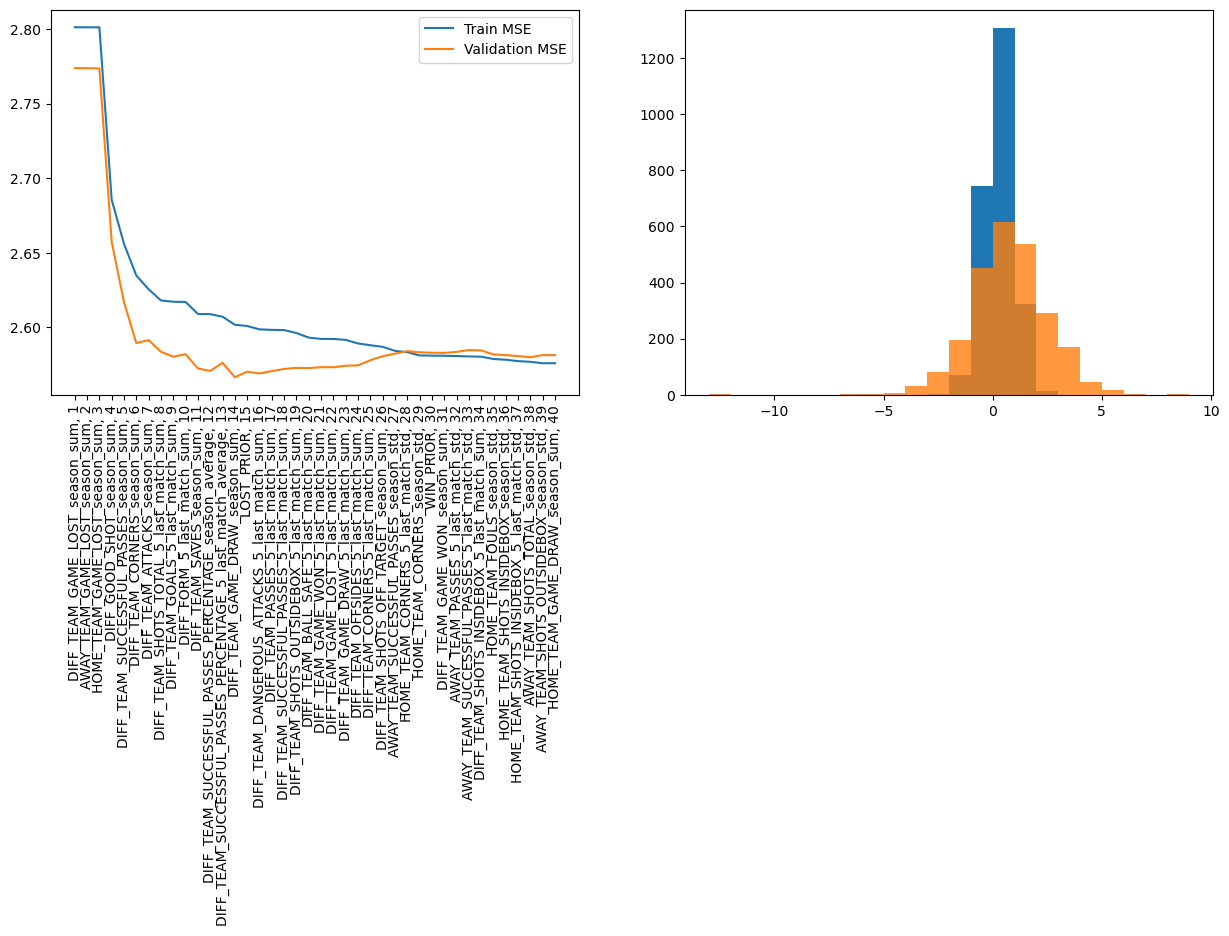

Number of correct scores: 0.268
Number of correct results: 0.433
Number of Wins: 0.359;  Number of win with correct score: 0.087
Number of Draws: 0.528; Number of loss with correct score: 0.151
Number of Losses: 0.113; Number of draw with correct score: 0.03
MSE: 2.566

----------------------------------------


In [14]:
p_max = 40
t_mse, v_mse, ranked_features, best_model =  forward_stepwise_selection_evaluation(p_max,  [X_train, y_train], 
                                                        [X_valid, y_valid])
fig, axs = plt.subplots(ncols = 2, figsize=(15, 5))

axs[0].plot(ranked_features, t_mse, label = 'Train MSE')
axs[0].plot(ranked_features, v_mse, label = 'Validation MSE')
axs[0].legend()
axs[0].set_xticks(ranked_features, labels = [f"{f}, {i+1}" for i, f in enumerate(ranked_features)], rotation = 90)

axs[1].hist(best_model[0].predict(X_valid[best_model[1]]), alpha = 1, bins = bins)
axs[1].hist(y_valid, alpha = 0.8, bins = bins)
plt.show()
check_predictions(best_model[0].predict(X_valid[best_model[1]]), y_valid['GOAL_DIFF_HOME_AWAY'])

In [15]:
print(*enumerate(ranked_features), sep = '\n')

(0, 'DIFF_TEAM_GAME_LOST_season_sum')
(1, 'AWAY_TEAM_GAME_LOST_season_sum')
(2, 'HOME_TEAM_GAME_LOST_season_sum')
(3, 'DIFF_GOOD_SHOT_season_sum')
(4, 'DIFF_TEAM_SUCCESSFUL_PASSES_season_sum')
(5, 'DIFF_TEAM_CORNERS_season_sum')
(6, 'DIFF_TEAM_ATTACKS_season_sum')
(7, 'DIFF_TEAM_SHOTS_TOTAL_5_last_match_sum')
(8, 'DIFF_TEAM_GOALS_5_last_match_sum')
(9, 'DIFF_FORM_5_last_match_sum')
(10, 'DIFF_TEAM_SAVES_season_sum')
(11, 'DIFF_TEAM_SUCCESSFUL_PASSES_PERCENTAGE_season_average')
(12, 'DIFF_TEAM_SUCCESSFUL_PASSES_PERCENTAGE_5_last_match_average')
(13, 'DIFF_TEAM_GAME_DRAW_season_sum')
(14, 'LOST_PRIOR')
(15, 'DIFF_TEAM_DANGEROUS_ATTACKS_5_last_match_sum')
(16, 'DIFF_TEAM_PASSES_5_last_match_sum')
(17, 'DIFF_TEAM_SUCCESSFUL_PASSES_5_last_match_sum')
(18, 'DIFF_TEAM_SHOTS_OUTSIDEBOX_5_last_match_sum')
(19, 'DIFF_TEAM_BALL_SAFE_5_last_match_sum')
(20, 'DIFF_TEAM_GAME_WON_5_last_match_sum')
(21, 'DIFF_TEAM_GAME_LOST_5_last_match_sum')
(22, 'DIFF_TEAM_GAME_DRAW_5_last_match_sum')
(23, 'DIFF_TE

We see from this plot that we should use somewhere in the range of 10-20 params. Thankfully, a few things can be noticed:

- The most important features are the number of wins and losses. It seems like all of our engineered features are doing well. 
- That the most important features are Diffs (and therefore sums) both from the season and the last 5 matches. The std terms aren't important (although note that last 5 goal std is in the form metric).
- As a classifier for our final task it is not doing too badly: it gets the correct score 25% of the time and the correct result 44%.
- There is a problem, and that is its vast overestimation of draws. I think the reason for this is the assumpition of a linear relation (the $R^2$ is only 0.12). I think a non linear model (along with oversampling the out lyers) might help. I think (and I might be wrong) that it is badly underpredicting the number of good wins (the right hand tail). We are predicting the draws correctly about 50% of the time, however we are prediciting that half of the data set are draws. 
- We **don't** use the upsampled data as it makes the fit go horribly wrong: in order to have such extreme values, the model has to make the coefficents much larger (as its a linear model), this makes the prediction in the centre much worse so when the validation score is caluculated it is rubbish.

Out of interest, lets see that if we have a quadratic model can we predict more of the outlyers. 

Number of features: 679
MSE Valid: 2.8121
MSE Train: 2.4488
----------------------------------------


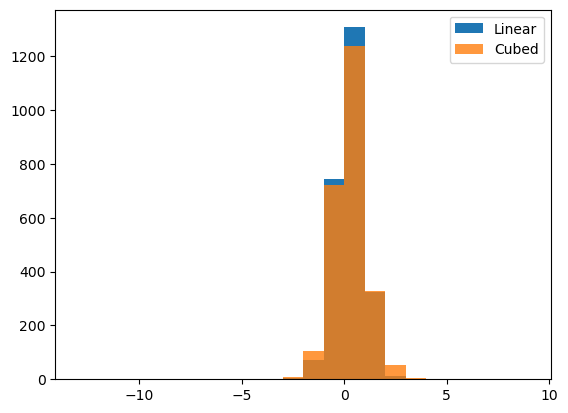

Number of correct scores: 0.251
Number of correct results: 0.409
Number of Wins: 0.365;  Number of win with correct score: 0.085
Number of Draws: 0.506; Number of loss with correct score: 0.137
Number of Losses: 0.129; Number of draw with correct score: 0.028
MSE: 2.812

----------------------------------------


In [16]:
degree = 3
def get_poly_features(X, degree):
    poly = PolynomialFeatures(degree,include_bias = False)
    X_poly = poly.fit_transform(X)
    return X_poly
    
def fitting_goals_polynomial(train_data, valid_data, degree = 1):
    X_train_poly, X_valid_poly = get_poly_features(train_data[0], degree), get_poly_features(valid_data[0], degree)
    model = LinearRegression(fit_intercept = True)
    model.fit(X_train_poly, y_train)
    print(f"Number of features: {X_train_poly.shape[1]}")
    print(f"MSE Valid: {np.round(mean_squared_error(model.predict(X_valid_poly), valid_data[1]),4)}")
    print(f"MSE Train: {np.round(mean_squared_error(model.predict(X_train_poly), train_data[1]),4)}")
    print(f"{'-'*40}")
    return model

plt.hist(best_model[0].predict(X_valid[best_model[1]]), alpha = 1, bins = bins, label = 'Linear')

model = fitting_goals_polynomial([X_train[best_model[1]], y_train], [X_valid[best_model[1]], y_valid], degree = degree)
plt.hist(model.predict(get_poly_features(X_valid[best_model[1]], degree)), bins  = bins, alpha = 0.8, label = 'Cubed')
plt.legend()
plt.show()

check_predictions(model.predict(get_poly_features(X_valid[best_model[1]], degree)), y_valid['GOAL_DIFF_HOME_AWAY'])


So we do get more extreme values, however we get worse results due to overfitting (we now have approx 560 features...).


## Fitting Goal Difference

We will fit the goal difference using the follow models:

- Linear Regression
- kNN
- Random Forest
- Ada Boost 
- Bagging Regressor 
- Gradient Boosting Resgressor
- Neural Net

What we will do in the following section is fit each of the above models with both the standard training set and the up_sampled training set. We will use CV to tune the hyper params. 

In [21]:
def fit_gd_regressor(model_type, model_params = None, analytics = False, up_sampled = False):
    ''' Fits a model to the data give with the model_params. Then prints analytics so we get an idea of the model'''
    X, y = (X_train_upsampled[best_model[1]], y_train_upsampled) if up_sampled else (X_train[best_model[1]], y_train)
    
    model_params = {} if model_params is None else model_params
    
    model = model_type(**model_params)
    model.fit(X, y)

    if analytics:
        print(model_params)
        print(f"MSE Valid: {np.round(mean_squared_error(model.predict(X_valid[best_model[1]]), y_valid['GOAL_DIFF_HOME_AWAY']),4)}")
        print(f"MSE Train: {np.round(mean_squared_error(model.predict(X[best_model[1]]), y),4)}")
        check_predictions(model.predict(X_valid[best_model[1]]), y_valid['GOAL_DIFF_HOME_AWAY'])
        
    return model

In [22]:
def find_gd_hyperparams(estimator, param_grid, up_sampled):
    '''Grid Searches for the best hyper params using CV, then return the best model fitting on the data'''
    X, y = (X_train_upsampled[best_model[1]], y_train_upsampled) if up_sampled else (X_train[best_model[1]], y_train)
    
    clf = GridSearchCV(estimator = estimator(), param_grid=param_grid, verbose = 1)
    clf.fit(X, y)
    return clf.best_params_

In [23]:
def plot_GD_residuals(normal_pred, up_pred):
    '''Plots the predicted GD using the normal data and upsampled data'''
    true = y_valid['GOAL_DIFF_HOME_AWAY'].to_numpy().reshape(-1, 1)
    avg =  (0.5*(normal_pred+up_pred)).reshape(-1, 1)
    
    
    linear_res_fit = LinearRegression()
    linear_res_fit.fit(true, avg)
    r_squared = np.round(linear_res_fit.score(true, avg),2)
    plt.plot([-10,10], linear_res_fit.predict([[-10],[10]]), label = f"Average")
    plt.scatter(true, avg, s = .1)
    

    linear_normal_fit, linear_up_fit = LinearRegression(), LinearRegression()
    linear_normal_fit.fit(true, normal_pred)
    linear_up_fit.fit(true, up_pred)
    plt.plot([-10,10], linear_normal_fit.predict([[-10],[10]]), label = 'Normal Data Fit')
    plt.plot([-10,10], linear_up_fit.predict([[-10],[10]]), label = 'Upsampled Data Fit') 
    
    plt.xlabel("True GD")
    plt.ylabel("Avg Balenced and Imbalenced")
    plt.title(f"Grad {np.round(linear_res_fit.coef_[0][0],2)}; R2: {r_squared}")
    plt.legend()
    plt.show()

#### Linear 

Upsampled
{}
MSE Valid: 9.3011
MSE Train: 11.172
Number of correct scores: 0.134
Number of correct results: 0.453
Number of Wins: 0.455;  Number of win with correct score: 0.057
Number of Draws: 0.136; Number of loss with correct score: 0.032
Number of Losses: 0.41; Number of draw with correct score: 0.045
MSE: 9.301

----------------------------------------
Normal Sampling
{}
MSE Valid: 2.5665
MSE Train: 2.6017
Number of correct scores: 0.268
Number of correct results: 0.433
Number of Wins: 0.359;  Number of win with correct score: 0.087
Number of Draws: 0.528; Number of loss with correct score: 0.151
Number of Losses: 0.113; Number of draw with correct score: 0.03
MSE: 2.566

----------------------------------------


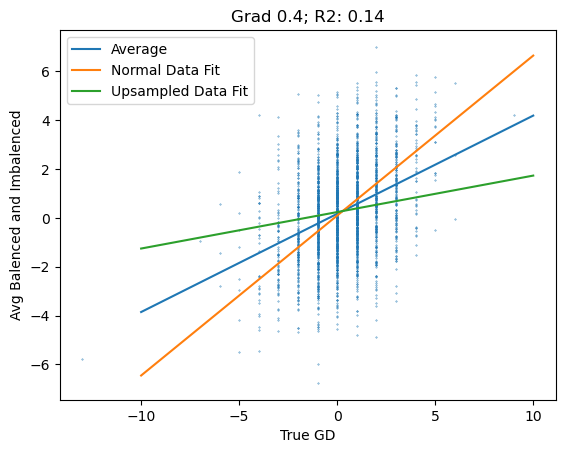

In [24]:
print('Upsampled')
linear_up = fit_gd_regressor(LinearRegression, analytics = True, up_sampled = True);
print('Normal Sampling')
linear_normal = fit_gd_regressor(LinearRegression, analytics = True, up_sampled = False);
plot_GD_residuals(linear_up.predict(X_valid[best_model[1]]), linear_normal.predict(X_valid[best_model[1]])[:,0])

#### KNN

Note, if the hyper params only contains one set of values, it is because we have found the best fit and only left those values there. 

In [44]:
knn_hyper_params = {'n_neighbors' : [5, 43], 
                    'p' :[1]}

KNN_up_hyp = find_gd_hyperparams(KNeighborsRegressor, knn_hyper_params, True)
KNN_normal_hyp = find_gd_hyperparams(KNeighborsRegressor, knn_hyper_params, False)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits


Upsampled
{'n_neighbors': 43, 'p': 1}
MSE Valid: 6.9101
MSE Train: 3.8418
Number of correct scores: 0.168
Number of correct results: 0.465
Number of Wins: 0.488;  Number of win with correct score: 0.077
Number of Draws: 0.159; Number of loss with correct score: 0.044
Number of Losses: 0.353; Number of draw with correct score: 0.047
MSE: 6.91

----------------------------------------
Normal Sampling
{'n_neighbors': 43, 'p': 1}
MSE Valid: 2.5982
MSE Train: 2.5587
Number of correct scores: 0.268
Number of correct results: 0.425
Number of Wins: 0.358;  Number of win with correct score: 0.088
Number of Draws: 0.535; Number of loss with correct score: 0.152
Number of Losses: 0.108; Number of draw with correct score: 0.027
MSE: 2.598

----------------------------------------


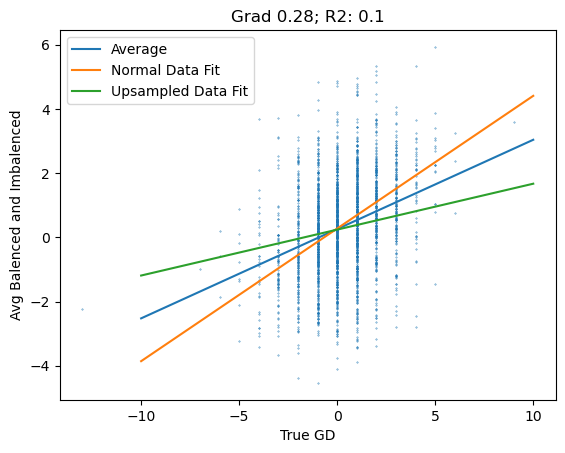

In [45]:
print('Upsampled')
KNN_up = fit_gd_regressor(KNeighborsRegressor, KNN_up_hyp, analytics = True, up_sampled = True);
print('Normal Sampling')
KNN_normal = fit_gd_regressor(KNeighborsRegressor, KNN_normal_hyp, analytics = True, up_sampled = False);
plot_GD_residuals(KNN_up.predict(X_valid[best_model[1]]), KNN_normal.predict(X_valid[best_model[1]])[:,0])

#### Random Forrest

In [46]:
rf_hyper_params = {'n_estimators' : 100, 
                    'min_samples_split' :6,
                  'criterion' :'squared_error'}

# rf_up_hyp = find_gd_hyperparams(RandomForestRegressor, rf_hyper_params, True)
# rf_normal_hyp = find_gd_hyperparams(RandomForestRegressor, rf_hyper_params, False)

Upsampled
{'n_estimators': 100, 'min_samples_split': 6, 'criterion': 'squared_error'}
MSE Valid: 3.2949
MSE Train: 0.1958
Number of correct scores: 0.227
Number of correct results: 0.45
Number of Wins: 0.409;  Number of win with correct score: 0.081
Number of Draws: 0.31; Number of loss with correct score: 0.087
Number of Losses: 0.281; Number of draw with correct score: 0.059
MSE: 3.295

----------------------------------------
Normal Sampling
{'n_estimators': 100, 'min_samples_split': 6, 'criterion': 'squared_error'}
MSE Valid: 2.6546
MSE Train: 0.5831
Number of correct scores: 0.253
Number of correct results: 0.408
Number of Wins: 0.352;  Number of win with correct score: 0.084
Number of Draws: 0.531; Number of loss with correct score: 0.143
Number of Losses: 0.116; Number of draw with correct score: 0.026
MSE: 2.655

----------------------------------------


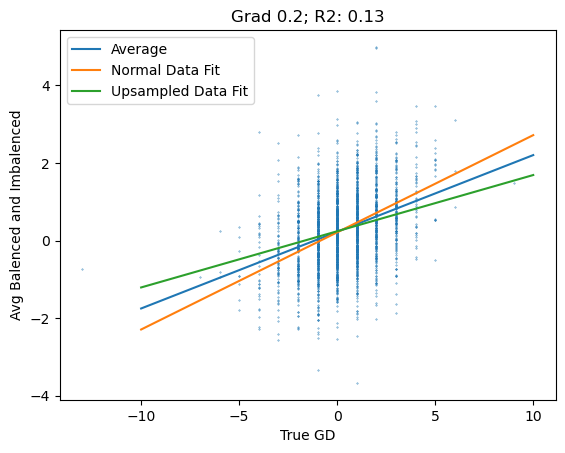

In [47]:
print('Upsampled')
rf_up = fit_gd_regressor(RandomForestRegressor, rf_hyper_params, analytics = True, up_sampled = True);
print('Normal Sampling')
rf_normal = fit_gd_regressor(RandomForestRegressor, rf_hyper_params, analytics = True, up_sampled = False);

plot_GD_residuals(rf_up.predict(X_valid[best_model[1]]), rf_normal.predict(X_valid[best_model[1]]))

#### Adaboost

In [36]:
ada_hyper_params = {'n_estimators' : [5,10], 
                   'loss': ['linear']}

ada_up_hyp = find_gd_hyperparams(AdaBoostRegressor, ada_hyper_params, True)
ada_normal_hyp = find_gd_hyperparams(AdaBoostRegressor, ada_hyper_params, False)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits


Upsampled
{'loss': 'linear', 'n_estimators': 10}
MSE Valid: 5.2268
MSE Train: 7.1759
Number of correct scores: 0.183
Number of correct results: 0.468
Number of Wins: 0.469;  Number of win with correct score: 0.078
Number of Draws: 0.167; Number of loss with correct score: 0.047
Number of Losses: 0.364; Number of draw with correct score: 0.058
MSE: 5.227

----------------------------------------
Normal Sampling
{'loss': 'linear', 'n_estimators': 5}
MSE Valid: 2.6909
MSE Train: 2.6666
Number of correct scores: 0.262
Number of correct results: 0.421
Number of Wins: 0.397;  Number of win with correct score: 0.098
Number of Draws: 0.501; Number of loss with correct score: 0.14
Number of Losses: 0.103; Number of draw with correct score: 0.024
MSE: 2.691

----------------------------------------


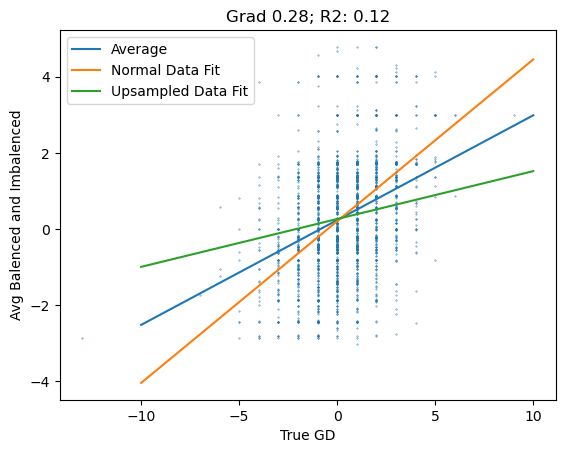

In [37]:
print('Upsampled')
ada_up = fit_gd_regressor(AdaBoostRegressor, ada_up_hyp, analytics = True, up_sampled = True);
print('Normal Sampling')
ada_normal = fit_gd_regressor(AdaBoostRegressor, ada_normal_hyp, analytics = True, up_sampled = False);

plot_GD_residuals(ada_up.predict(X_valid[best_model[1]]), ada_normal.predict(X_valid[best_model[1]]))

#### Bagging 

In [38]:
bag_hyper_params = {'max_features' : [1,2,3]}

bag_up_hyp = find_gd_hyperparams(BaggingRegressor, bag_hyper_params, True)
bag_normal_hyp = find_gd_hyperparams(BaggingRegressor, bag_hyper_params, False)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits


Upsampled
{'max_features': 3}
MSE Valid: 3.2051
MSE Train: 0.2996
Number of correct scores: 0.221
Number of correct results: 0.424
Number of Wins: 0.436;  Number of win with correct score: 0.089
Number of Draws: 0.307; Number of loss with correct score: 0.08
Number of Losses: 0.258; Number of draw with correct score: 0.052
MSE: 3.205

----------------------------------------
Normal Sampling
{'max_features': 2}
MSE Valid: 2.7744
MSE Train: 1.5037
Number of correct scores: 0.255
Number of correct results: 0.379
Number of Wins: 0.323;  Number of win with correct score: 0.077
Number of Draws: 0.594; Number of loss with correct score: 0.158
Number of Losses: 0.082; Number of draw with correct score: 0.02
MSE: 2.774

----------------------------------------


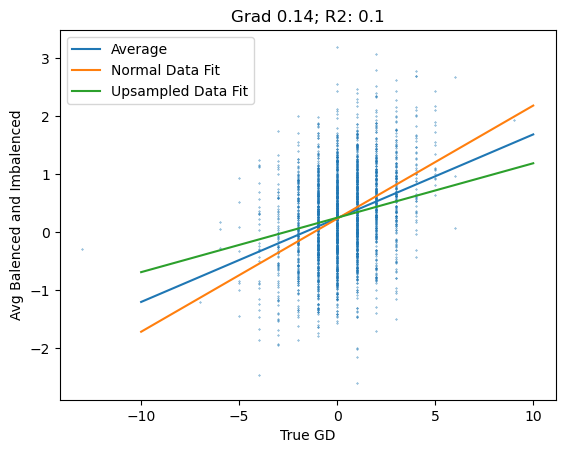

In [39]:
print('Upsampled')
bag_up = fit_gd_regressor(BaggingRegressor, bag_up_hyp, analytics = True, up_sampled = True);
print('Normal Sampling')
bag_normal = fit_gd_regressor(BaggingRegressor, bag_normal_hyp, analytics = True, up_sampled = False);

plot_GD_residuals(bag_up.predict(X_valid[best_model[1]]), bag_normal.predict(X_valid[best_model[1]]))

#### Gradient Boost

In [54]:
boost_hyper_params = {'n_estimators' : [5,35]}

boost_up_hyp = find_gd_hyperparams(GradientBoostingRegressor, boost_hyper_params, True)
boost_normal_hyp = find_gd_hyperparams(GradientBoostingRegressor, boost_hyper_params, False)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits


Upsampled
{'n_estimators': 35}
MSE Valid: 6.0411
MSE Train: 4.6887
Number of correct scores: 0.17
Number of correct results: 0.46
Number of Wins: 0.454;  Number of win with correct score: 0.068
Number of Draws: 0.187; Number of loss with correct score: 0.053
Number of Losses: 0.359; Number of draw with correct score: 0.05
MSE: 6.041

----------------------------------------
Normal Sampling
{'n_estimators': 35}
MSE Valid: 2.5948
MSE Train: 2.5437
Number of correct scores: 0.27
Number of correct results: 0.417
Number of Wins: 0.326;  Number of win with correct score: 0.079
Number of Draws: 0.584; Number of loss with correct score: 0.166
Number of Losses: 0.091; Number of draw with correct score: 0.025
MSE: 2.595

----------------------------------------


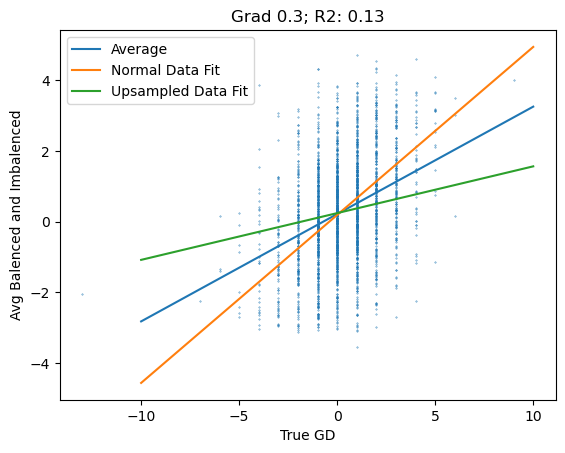

In [55]:
print('Upsampled')
boost_up = fit_gd_regressor(GradientBoostingRegressor, boost_up_hyp, analytics = True, up_sampled = True);
print('Normal Sampling')
boost_normal = fit_gd_regressor(GradientBoostingRegressor, boost_normal_hyp, analytics = True, up_sampled = False);

plot_GD_residuals(boost_up.predict(X_valid[best_model[1]]), boost_normal.predict(X_valid[best_model[1]]))

#### NN 

In [50]:
nn_hyper_params = {'hidden_layer_sizes' : [(100,)],
                     'activation': ['tanh'],
                      'early_stopping' : [True, False]}

nn_up_hyp = find_gd_hyperparams(MLPRegressor, nn_hyper_params, True)
nn_normal_hyp = find_gd_hyperparams(MLPRegressor, nn_hyper_params, False)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits


Upsampled
{'activation': 'tanh', 'early_stopping': True, 'hidden_layer_sizes': (100,)}
MSE Valid: 5.6883
MSE Train: 2.2476
Number of correct scores: 0.178
Number of correct results: 0.445
Number of Wins: 0.469;  Number of win with correct score: 0.074
Number of Draws: 0.176; Number of loss with correct score: 0.051
Number of Losses: 0.356; Number of draw with correct score: 0.054
MSE: 5.688

----------------------------------------
Normal Sampling
{'activation': 'tanh', 'early_stopping': True, 'hidden_layer_sizes': (100,)}
MSE Valid: 2.5953
MSE Train: 2.5844
Number of correct scores: 0.267
Number of correct results: 0.432
Number of Wins: 0.347;  Number of win with correct score: 0.087
Number of Draws: 0.507; Number of loss with correct score: 0.144
Number of Losses: 0.146; Number of draw with correct score: 0.037
MSE: 2.595

----------------------------------------


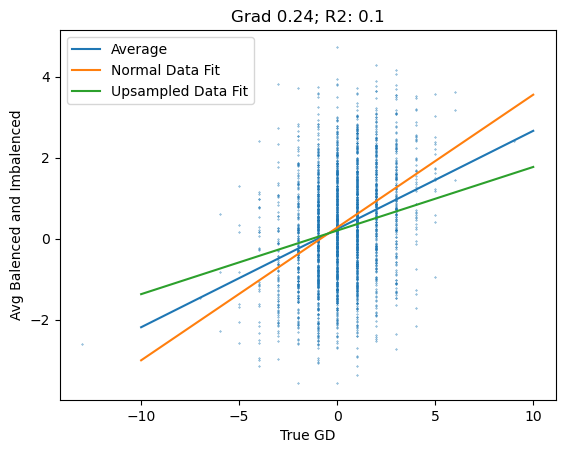

In [51]:
print('Upsampled')
nn_up = fit_gd_regressor(MLPRegressor, nn_up_hyp, analytics = True, up_sampled = True);
print('Normal Sampling')
nn_normal = fit_gd_regressor(MLPRegressor, nn_normal_hyp, analytics = True, up_sampled = False);

plot_GD_residuals(nn_up.predict(X_valid[best_model[1]]), nn_normal.predict(X_valid[best_model[1]]))

### Stacking Regressor

Looking at the MSE we will select the following models to stack:

Upsampled Data

- Bagging
- Random Forrest

Normal Data: All of them

#### Stacking the Balanced Data 

In [53]:
normal_regressors = [('l', linear_normal), 
                     ('kNN', KNN_normal),
                     ('ADA', ada_normal),  
                     ('Boost',boost_normal), 
                     ('NN',nn_normal)]

normal_stack = VotingRegressor(normal_regressors)
normal_stack.fit(X_train[best_model[1]], y_train)
print(f"MSE Valid: {np.round(mean_squared_error(normal_stack.predict(X_valid[best_model[1]]), y_valid['GOAL_DIFF_HOME_AWAY']),4)}")
print(f"MSE Train: {np.round(mean_squared_error(normal_stack.predict(X_train[best_model[1]]), y_train['GOAL_DIFF_HOME_AWAY']),4)}")
check_predictions(normal_stack.predict(X_valid[best_model[1]]), y_valid['GOAL_DIFF_HOME_AWAY'])

MSE Valid: 2.571
MSE Train: 2.5564
Number of correct scores: 0.272
Number of correct results: 0.427
Number of Wins: 0.353;  Number of win with correct score: 0.088
Number of Draws: 0.551; Number of loss with correct score: 0.157
Number of Losses: 0.095; Number of draw with correct score: 0.027
MSE: 2.571

----------------------------------------


In [33]:
from sklearn.ensemble import VotingRegressor
up_regressors = [('RF', rf_up), ('Bag', bag_up)]

# up_stack = StackingRegressor(up_regressors, final_estimator = RandomForestRegressor()) # Could we use a better way of combining these estimates
up_stack = VotingRegressor(up_regressors)
up_stack.fit(X_train_upsampled[best_model[1]], y_train_upsampled)
check_predictions(up_stack.predict(X_valid[best_model[1]]), y_valid['GOAL_DIFF_HOME_AWAY'])

Number of correct scores: 0.234
Number of correct results: 0.448
Number of Wins: 0.422;  Number of win with correct score: 0.09
Number of Draws: 0.33; Number of loss with correct score: 0.089
Number of Losses: 0.249; Number of draw with correct score: 0.055
MSE: 2.98

----------------------------------------


## Saving Data

Before we save the models, let test the predictions on the test data:

In [34]:
check_predictions(up_stack.predict(X_test[best_model[1]]), y_test['GOAL_DIFF_HOME_AWAY'])
check_predictions(normal_stack.predict(X_test[best_model[1]]), y_test['GOAL_DIFF_HOME_AWAY'])

Number of correct scores: 0.234
Number of correct results: 0.448
Number of Wins: 0.422;  Number of win with correct score: 0.09
Number of Draws: 0.33; Number of loss with correct score: 0.089
Number of Losses: 0.249; Number of draw with correct score: 0.055
MSE: 2.98

----------------------------------------
Number of correct scores: 0.268
Number of correct results: 0.407
Number of Wins: 0.325;  Number of win with correct score: 0.081
Number of Draws: 0.591; Number of loss with correct score: 0.163
Number of Losses: 0.084; Number of draw with correct score: 0.025
MSE: 2.592

----------------------------------------


i.e. its working.

let us now save the models to file

In [35]:
# with open('goal_diff_prediction/upsampled_DG_predictor.pkl', 'wb') as f:
#     pickle.dump(up_stack, f)

In [56]:
with open('goal_diff_prediction/normal_sampled_DG_predictor.pkl', 'wb') as f:
    pickle.dump(normal_stack, f)

In [57]:
model_features = pd.DataFrame({'Feature' : best_model[1]}) # This will allow us to read in the features for the model
model_features.to_csv('goal_diff_prediction/Features.csv', index = False)

## Conclusion 

In this notebook we have generated two regressive models to predict the goal difference. We have done this in two different ways:
1. We have use the true data proportions: this gives a better prediction accuracy, however it over predicts the number of small GD (as this is where the majority of games exist, it is easier to minimse MSE like this). We note that test methods predict A LOT of draws (sometimes over 60%), it might therefore be worth not bothering to predict draws as this will be v hard to do.  
2. Trained on upsampled data, so that the number of games with each goal difference is the same. As expected this has a worse MSE, however it is better at predicting which team wins (there is less bias towards small scores).

We also note that all of our engineered features seem to be working well. 